# Sweeps - Eigenmode matrix

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.analyses.sweep_options.sweeping import Sweeping

In [3]:
# Create the design in Metal
# Create a design by specifying the chip size and open Metal GUI.

design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

### In this example, the design consists of 1 qubit and 1 CPW connected to OpenToGround.

In [4]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

# Remove all qcomponents from GUI.
design.delete_all_components()

# So as to demonstrate the quality factor outputs easily, the
#subtrate material type is being changed to FR4_epoxy from the
#default of silicon
design.chips.main.material = 'FR4_epoxy'

q1 = TransmonPocket(
    design,
    'Q1',
    options=dict(pad_width='425 um',
                 pocket_height='650um',
                 connection_pads=dict(
                     readout=dict(loc_W=+1, loc_H=+1, pad_width='200um'))))
otg = OpenToGround(design,
                   'open_to_ground',
                   options=dict(pos_x='1.75mm', pos_y='0um', orientation='0'))
readout = RouteMeander(
    design, 'readout',
    Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead=dict(start_straight='100um'),
        pin_inputs=Dict(start_pin=Dict(component='Q1', pin='readout'),
                        end_pin=Dict(component='open_to_ground', pin='open')),
    ))

gui.rebuild()
gui.autoscale()

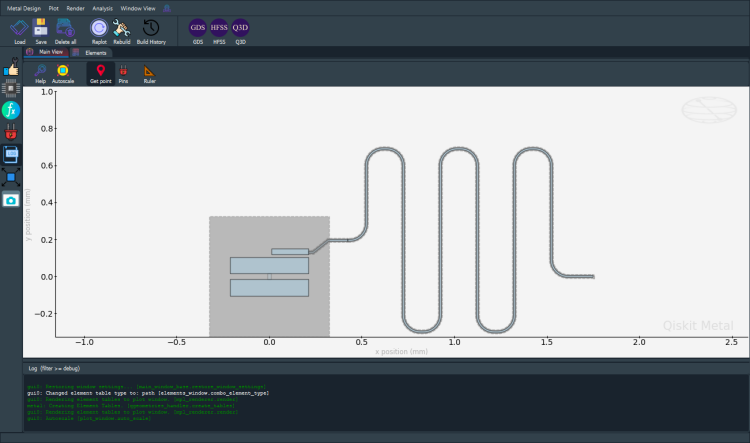

In [5]:
gui.screenshot()

## 2. Must open Ansys HFSS at this point.
### Registration occurs automatically within the method "sweep_one_option_get_eigenmode_solution_data". 

### Must have an open Ansys project and HFSS eigenmode design before executing render_design. Can do it manually or automate it.

Manually: To create a new Ansys project, click "New", the leftmost icon right below the file menu. 

Automate: Use the cells below to open the Ansys application.  The method sweep_one_option_get_eigenmode_solution_data will connect to ansys, activate a HFSS design, and add a setup.

In [6]:
# This cell will open the Ansys application.  Run this cell, if Ansys, is not already open.
# A project will be opened using this command.
hfss = design.renderers.hfss
#hfss.open_ansys()

In [7]:
### for render_design()
# Render every QComponent in QDesign.
render_qcomps = []

# Identify which kind of pins in Ansys. 
# Follow details from renderer in
# QHFSSRenderer.render_design.
# No pins are open, so don't need to utilize ender_endcaps.
render_endcaps = []

#List of tuples of jj's that shouldn't be rendered.  
#Follow details from renderer in QHFSSRenderer.render_design.
render_ignored_jjs = [('Q1','rect_jj')]

# Either calculate a bounding box based on the location of 
# rendered geometries or use chip size from design class.
render_box_plus_buffer = True



sweep = Sweeping(design)

In [8]:
# Pass a dict with arguments to be used add Setup to project.
# If you don't pass all the arguments, the default is determined by 
# QHFSSRenderer's default_options.

# The name of setup will be "Sweep_em_setup".  
# If a setup named "Sweep_em_setup" exists in the project, it will be deleted, 
# and a new setup will be added with the arguments from setup_args.
em_setup_args = Dict(min_freq_ghz=None,
                  n_modes=None,
                  max_delta_f=None,
                  max_passes=None,
                  min_passes=None,
                  min_converged=None,
                  pct_refinement=None,
                  basis_order=None)

# Example of updating the keys that we are interested in. 
em_setup_args = Dict(min_freq_ghz=5,
                  n_modes=2,
                  max_passes=9,)

## 3 Metal pass information to Ansys, and gets a solution matrix.
- Connect to Ansys HFSS, eigenmode solution.
- Rebuild QComponents in Metal.
- Render QComponents within HFSS and setup.
- Delete/Clear the HFSS between each calculation of solution matrix.
- Calculate solution matrix for each value in option_sweep.

#### Return a dict and return code.  If the return code is zero, there were no errors detected.  
#### The dict has:  key = each value used to sweep, value = Dict with frequency, kappa_over_2pis, and quality_factor.

#### This could take minutes based size of design.

In [9]:
#The argument "leave_last_design" is true by default.  

#Note: The method will connect to Ansys, activate_eigenmode_design(), add_eigenmode_setup().

all_sweeps, return_code = sweep.sweep_one_option_get_eigenmode_solution_data(
    readout.name,
    'total_length', 
    ['5.8mm', '6mm', '6.2mm'],
    render_qcomps,
    render_endcaps,
    render_ignored_jjs,
    box_plus_buffer_render=render_box_plus_buffer,
    design_name="GetEigenModeSolution",
    setup_args=em_setup_args)


INFO 02:53PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:53PM [load_ansys_project]: 	Opened Ansys App
INFO 02:53PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:53PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 02:53PM [connect_design]: No active design found (or error getting active design).
INFO 02:53PM [connect]: 	 Connected to project "Project16". No design detected
02:53PM 35s WARNING [activate_eigenmode_design]: The name=GetEigenModeSolution was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 02:53PM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution [Solution type: Eigenmode]
WARNING 02:53PM [connect_setup]: 	No design setup detected.
WARNING 02:53PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:53PM [get_setup]: 	O

Warning! 6 COM references still alive
Ansys will likely refuse to shut down


In [10]:
if return_code ==0:
    print(f'{all_sweeps.keys()} \n')
    for key in all_sweeps.keys():
        print(f'\nkey={key}')
        option_name = all_sweeps[key]['option_name']
        print(f'option_name[\'{key}\'][\'option_name\']={option_name}')
        did_converge = all_sweeps[key]['convergence']
        print(f'convergence: {did_converge}')
        print('frequency:')
        print(all_sweeps[key]['frequency'])
        print('kappa_over_2pis:')
        print(all_sweeps[key]['kappa_over_2pis'])
        print('quality_factor:')
        print(all_sweeps[key]['quality_factor'])
        print('convergence_t:\n')
        print(all_sweeps[key]['convergence_t'])
        print('convergence_eig_f:\n')
        print(all_sweeps[key]['convergence_eig_f'])
     

dict_keys(['5.8mm', '6mm', '6.2mm']) 


key=5.8mm
option_name['5.8mm']['option_name']=total_length
convergence: False
frequency:
[14.596220631, 29.0302250618]
kappa_over_2pis:
[0.234400176082, 0.464771726948]
quality_factor:
[62.270519054106074, 62.46125437197255]
convergence_t:

             Solved Elements  Max Delta Freq. %
Pass Number                                    
1                       6683                NaN
2                       8693            16.4140
3                       8974             4.9010
4                       9580             3.4668
5                      10935             2.6866
6                      13132             4.3141
7                      16510             4.4199
8                      21171             2.3156
9                      26560             1.4620
convergence_eig_f:

         re(Mode(1)) [g]  re(Mode(2)) [g]
Pass []                                  
1              12.246117        23.523322
2              14.256174        27.113274
3  

In [11]:
# For example, just one group of solution data.
all_sweeps['6mm']

{'convergence': False,
 'option_name': 'total_length',
 'frequency': [14.0368480685, 27.7418111455],
 'kappa_over_2pis': [0.225261999166, 0.442295541684],
 'quality_factor': [62.313431117851216, 62.72233954671029],
 'convergence_eig_f':          re(Mode(1)) [g]  re(Mode(2)) [g]
 Pass []                                  
 1              12.046058        24.072228
 2              13.456840        25.293490
 3              13.410678        25.515569
 4              12.736392        25.436257
 5              12.301311        24.943946
 6              13.014545        25.723834
 7              13.347765        26.459584
 8              13.843043        27.298293
 9              14.036848        27.741811,
 'convergence_t':              Solved Elements  Max Delta Freq. %
 Pass Number                                    
 1                       6451                NaN
 2                       8391           11.71200
 3                       9657            0.87801
 4                      1027

In [12]:
# In HFSS, after the last sweep, should the design be cleared?  The argument "leave_last_design" is true by default. 
# If you want to delete after last sweep, change argument to false.

leave_last_design = False

all_sweeps, return_code = sweep.sweep_one_option_get_eigenmode_solution_data(
                                q1.name,
                                'connection_pads.readout.pad_width', 
                                ['100um', '110um', '120um'],
                                render_qcomps,
                                render_endcaps,
                                render_ignored_jjs,
                                box_plus_buffer_render=render_box_plus_buffer,
                                design_name="GetEigenModeSolution",
                                leave_last_design=leave_last_design,
                                setup_args=em_setup_args)

INFO 02:56PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:56PM [load_ansys_project]: 	Opened Ansys App
INFO 02:56PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:56PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 02:56PM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution [Solution type: Eigenmode]
INFO 02:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:56PM [connect]: 	Connected to project "Project16" and design "GetEigenModeSolution" 😀 

INFO 02:56PM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution [Solution type: Eigenmode]
INFO 02:56PM [get_setup]: 	Opened setup `Sweep_em_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:56PM [get_setup]: 	Opened setup `Sweep_em_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:56PM [analyze]: Analyzing setup Sweep_em_setup
02:57PM 40s INFO [hfss_report_f_convergence]: Saved convergen

Warning! 6 COM references still alive
Ansys will likely refuse to shut down


In [13]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()